In [1]:
import torch
from my_snn.rsnn import RSNN, RSNN_2l, RSNN_2l_ALIF
from my_snn.utils import train, training_plots, ModelLoader
from my_snn.tonic_dataloader import DatasetLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Running on: {}'.format(device))

Running on: cuda:0


In [2]:
dataset = 'shd' 
time_window = 50
batch_size = 256 # lr=1e-4
DL = DatasetLoader(dataset=dataset, caching='memory', num_workers=0, batch_size=batch_size, time_window=time_window)
data = DL.get_dataloaders()

### Fixed-structure Recurrent SNNs
There are three classes for 'fixed structure' SNNs, located in *my_snn.rsnn*
- **RSNN**: 1 hidden recurrent
- **RSNN_2l**: 2 hidden recurrent layers
- **RSNN_2l_ALIF**: 2 hidden recurrent layers + adaptive threshold

Their initialization arguments are:
- **dataset used**: Name of the dataset. It is used for the SNN to know the input/output dimensionality. either:
    - nmnist
    - smnist
    - shd
    - DVSGesture_32
    - DVSGesture
    - custom_{num_input}_{num_outputs}_{num_training_samples}
- **num_hidden**: Number of neuron in the hidden layer(s)
- **thresh**: Neuron's threshold (or baseline theshold for the ALIF)
- **tau_m**: The membrane's time constant Either:
    - str-> 'adp', for trainable time constant [default]
    - float-> A real positive number to make all time constants fixed to that value, and untrainable
- **win**: Number of timesteps per sample. Set it to be the same as the one used in your dataset.
- **surr**: Surrogate function used: can be either:
    - 'step' [default] 
    - 'fs': fast sigmoid,
    - 'mg': multi-gaussian
- **loss_fn**: The method to compute the loss function can be either
    - mot [default]: the winner output neuron is the one with maximum membrane potential over time. Neurons have infinite threshold (never fire). It uses nn.CrossEntropyLoss()
    - sum of spikes: the winner output neuron is the one which fires the most. It uses nn.MSELoss()
    - prediction: Used for the addition task and similar. The loss is computed as the nn.MSELoss() between a reference and a single output's neuron membrane potential in the 20% last timesteps.
- **batch_size**: batch size
- **device**: cuda or cpu
- **debug**: boolean, set True if you want to store internal states (membrane and spikes) for all neurons and layers. Uses more memory, so it's recommended for testing.
 

#### Instantiation
Let's use a typical 2-layer RSNN, and name is as 'rsnn_2l_example2.t7

In [3]:
snn = RSNN_2l(dataset, num_hidden=128, thresh=0.3, tau_m='adp', win=time_window, surr='fs', loss_fn ='mot', batch_size=256, device=device)
snn.modelname = 'rsnn_2l_example2.t7'
snn.to(device)

RSNN_2l(
  (criterion): CrossEntropyLoss()
  (fc_ih): Linear(in_features=700, out_features=128, bias=False)
  (fc_h1h1): Linear(in_features=128, out_features=128, bias=False)
  (fc_h1h2): Linear(in_features=128, out_features=128, bias=False)
  (fc_h2h2): Linear(in_features=128, out_features=128, bias=False)
  (fc_ho): Linear(in_features=128, out_features=20, bias=False)
)

#### Accessing layers
Just as with any pythorch neural network, you can access their layers and weights

In [4]:
print(snn.fc_h1h1)
print(snn.fc_h1h2)
print(snn.fc_h2h2.weight.data)

Linear(in_features=128, out_features=128, bias=False)
Linear(in_features=128, out_features=128, bias=False)
tensor([[-0.0298, -0.0707,  0.0177,  ..., -0.0646, -0.0153, -0.0724],
        [-0.0300, -0.0740,  0.0030,  ..., -0.0824,  0.0235, -0.0090],
        [ 0.0683, -0.0399,  0.0488,  ...,  0.0181, -0.0025, -0.0116],
        ...,
        [ 0.0452,  0.0552,  0.0365,  ...,  0.0014, -0.0523, -0.0405],
        [-0.0058,  0.0086,  0.0798,  ..., -0.0114, -0.0776, -0.0221],
        [ 0.0488,  0.0557, -0.0728,  ..., -0.0150,  0.0688, -0.0132]],
       device='cuda:0')


Also the membrane's tau are accessible.\
Note: For RSNN_2l and RSNN_2l_Alif these are not the proper membrane taus. \
alpha = sigmoid(tau_m_h) \
alpha = exp(-1/proper_tau) \
proper_tau = -1/log(alpha) \
proper_tau = -1/log(sigmoid(tau_m_h))

In [5]:
print(snn.tau_m_h_1)
print(snn.tau_m_h_2)

Parameter containing:
tensor([ 6.0069, 13.0306, 25.1231,  1.6824, 12.3083,  1.7864,  8.9747,  6.2091,
        16.3426, 14.6647, 10.4712,  1.1709, 10.5354, 19.1053,  4.0617, 14.9453,
        53.2739, 21.3883,  6.4078, 14.7623, 10.2050,  6.8095, 23.5726,  9.4761,
        15.7442,  3.9728,  7.7620,  6.3167,  8.3355, 17.5246, 12.1639, 10.1163,
         9.4027,  2.7518, 10.4945, 17.4519, 11.5137, 10.1961,  0.9175,  2.1918,
         2.5792,  2.5958,  9.5757, 12.0445, 15.2526,  7.6731,  4.2477,  9.0365,
        27.3149,  3.8583,  2.7871,  2.4368,  9.8633, 22.8871, 14.9152,  0.7906,
         9.3687,  8.4961,  8.5091,  6.5448, 17.8005,  3.4879,  5.5095, 11.6868,
        20.4334,  6.8693, 22.1189,  2.5938,  8.8147, 15.8848,  5.8365, 12.9375,
         3.3748, 10.5716, 14.3149,  3.1442,  5.2277, 24.3913,  4.6048, 15.4059,
        13.9286, 18.8096,  5.7281,  8.1293, 10.9061,  8.8109, 13.8728,  9.5865,
         2.7248, 11.3523, 11.7269,  4.4865,  4.2328,  5.5605, 23.6047, 13.8369,
         3.2185, 1

#### Plotting distributions

use **plot(parameter, mode: 'matrix' or 'histogram')** if you want to plot the parameters individually

<AxesSubplot:>

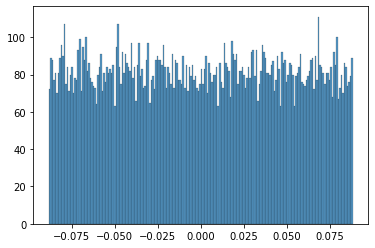

In [6]:
snn.plot(snn.fc_h1h1, 'histogram')

<AxesSubplot:title={'center':'weights'}, xlabel='input', ylabel='output'>

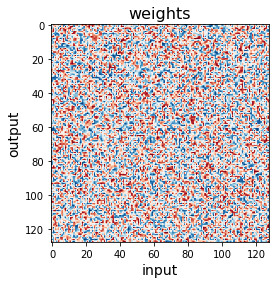

In [7]:
snn.plot(snn.fc_h1h1, 'matrix')

For a more sumarized graph, use **plot_distributions(mode: 'weights' or 'taus')**

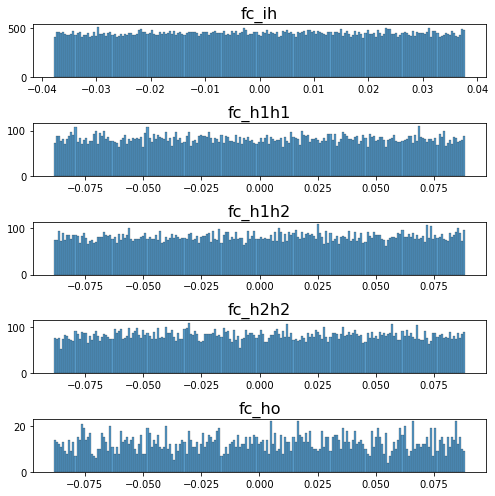

In [8]:
ax = snn.plot_distributions()

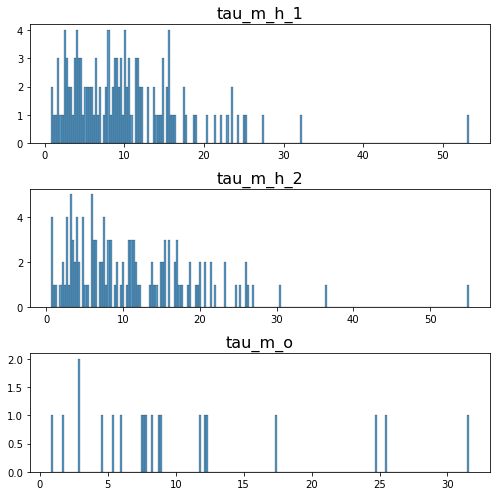

In [9]:
ax = snn.plot_distributions('taus')

In [10]:
ckpt_dir = 'examples'
train(snn, data, learning_rate=1e-3, lr_scale = (5.0, 5.0), num_epochs=50, ckpt_dir=ckpt_dir)

RSNN_2l(
  (criterion): CrossEntropyLoss()
  (fc_ih): Linear(in_features=700, out_features=128, bias=False)
  (fc_h1h1): Linear(in_features=128, out_features=128, bias=False)
  (fc_h1h2): Linear(in_features=128, out_features=128, bias=False)
  (fc_h2h2): Linear(in_features=128, out_features=128, bias=False)
  (fc_ho): Linear(in_features=128, out_features=20, bias=False)
)
Total params: 141312
Total mult-adds (M): 7.0656
training rsnn_2l_example2.t7 for 50 epochs...
Epoch [1/50]
Step [10/31], Loss: 4.75441
Step [20/31], Loss: 4.35182
Step [30/31], Loss: 3.68136
Time elasped: 62.877934217453
Epoch [2/50]
Step [10/31], Loss: 3.68905
Step [20/31], Loss: 3.41112
Step [30/31], Loss: 3.33327
Time elasped: 7.550833463668823
Epoch [3/50]
Step [10/31], Loss: 3.25146
Step [20/31], Loss: 3.04298
Step [30/31], Loss: 3.06665
Time elasped: 5.633486986160278
Epoch [4/50]
Step [10/31], Loss: 2.89920
Step [20/31], Loss: 2.70428
Step [30/31], Loss: 2.69520
Time elasped: 5.578370809555054
Epoch [5/50]
Ste

Step [20/31], Loss: 0.06349
Step [30/31], Loss: 0.10994
Time elasped: 5.654945611953735
Test Loss: 1.2375596761703491
Avg spk_count per neuron for all 50 timesteps 11.777994155883789
Test Accuracy of the model on the test samples: 74.561


#### Tau distribution after training

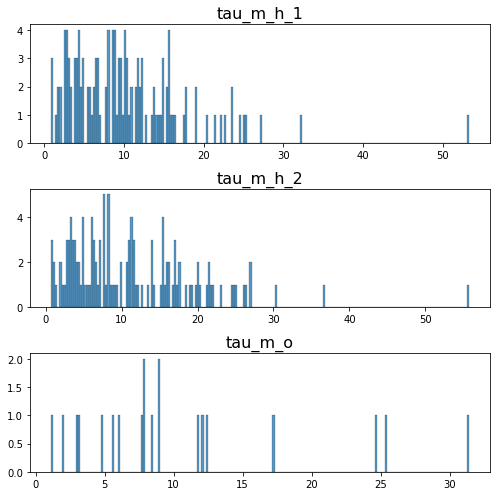

In [11]:
ax = snn.plot_distributions('taus')